# Computer Vision Projects

## Mosaicing and image stiching

In [1]:
import utils
import cv2
import matplotlib.pyplot as plt

The number of keypoints with sift is 4187


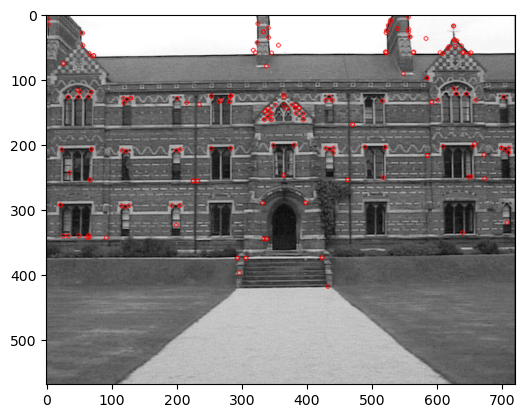

In [8]:
img_gs_b = cv2.imread('./images/keble_b.jpg', cv2.IMREAD_GRAYSCALE)
kp_b, d_b = utils.get_the_N_information(img_gs_b)

The number of keypoints with sift is 4014


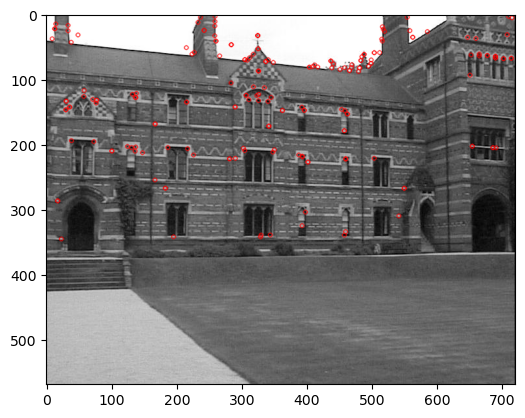

In [9]:
img_gs_c = cv2.imread('./images/keble_c.jpg', cv2.IMREAD_GRAYSCALE)
kp_c, d_c = utils.get_the_N_information(img_gs_c)

In [10]:
# Create the correspondances
correspondances2 = utils.create_correspondances(d_c, d_b)
print('There are {} correspondances out of 200.'.format(len(correspondances2)))

There are 56 correspondances out of 200.


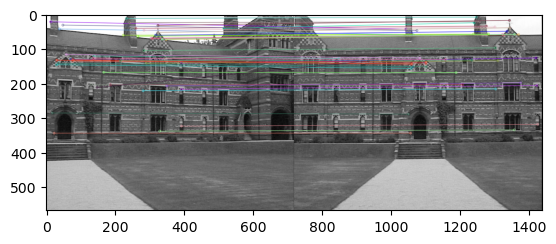

(<matplotlib.image.AxesImage at 0x11320b680>, None)

In [11]:
# Show the matches
matches2 = cv2.drawMatches(img_gs_c, kp_c, img_gs_b, kp_b, correspondances2, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(matches2),plt.show()

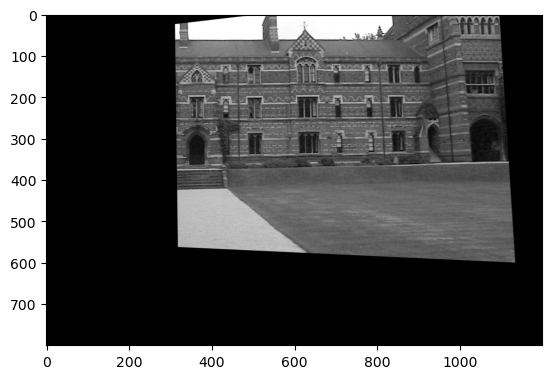

In [37]:
p1, p2 = utils.get_points(correspondances2, kp_c, kp_b)
H, inliners = utils.RANSAC(p1, p2, 10)

transformed_b = cv2.warpPerspective(img_gs_c, H, (1200,800))
plt.imshow(transformed_b, cmap='gray')

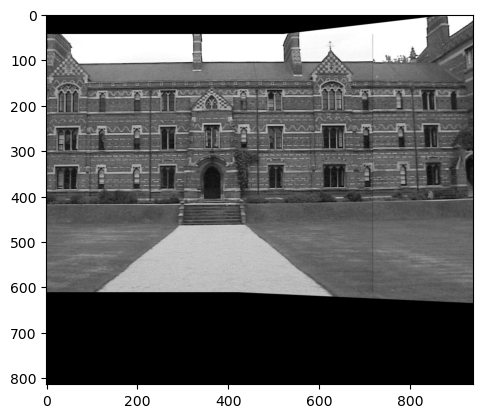

In [117]:
import numpy as np

def create_mosaic(reference, trans_image, H):
    w_r, h_r = reference.shape[:2]
    w_t, h_t = trans_image.shape[:2]

    corners = np.float32([[0, 0], [w_t, 0], [0, h_t], [w_t, h_t]])
    corners_homg = np.append(corners, np.ones((4, 1)), axis=1).T
    corners_homog_transf = np.dot(H, corners_homg)
    corners_homog_transf = corners_homog_transf / corners_homog_transf[-1, :]

    corners_r = np.float32([[0, 0], [w_r, 0], [0, h_r], [w_r, h_r]]).T
    all_corners = np.concatenate((corners_homog_transf[:2], corners_r),axis=1)

    min_x = min(all_corners[0])
    max_x = max(all_corners[0])
    min_y = min(all_corners[1])
    max_y = max(all_corners[1])
    panomara_size = (int(np.sqrt((max_x - min_x)**2)), int(np.sqrt((max_y - min_y)**2)))

    # Calculate translation to avoid crop the image
    tx = min(0, np.min(corners_homog_transf[0, :], axis=0))
    ty = min(0, np.min(corners_homog_transf[1, :], axis=0))
    T = np.float32([[1], [0], [-tx], [0], [1], [-ty], [0], [0], [1]]).reshape((3, 3))

    transformed_image = cv2.warpPerspective(trans_image, T.dot(H), panomara_size)
    transformed_image[int(abs(ty)):int(abs(ty)+w_r), int(abs(tx)):int(abs(tx)+h_r)] = reference
    plt.imshow(transformed_image, cmap='gray')
    return
    # import pdb; pdb.set_trace()

reference_image = cv2.imread('images/keble_b.jpg', cv2.IMREAD_GRAYSCALE)
transform_image = cv2.imread('images/keble_c.jpg', cv2.IMREAD_GRAYSCALE)

create_mosaic(reference_image, transform_image,H)


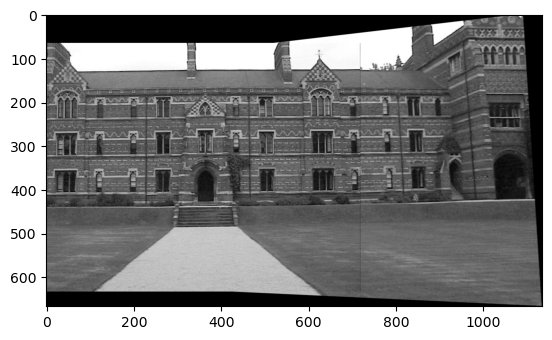

In [187]:
def create_panorama(reference_image, transform_image, H):
    hr, wr = reference_image.shape[:2]
    ht, wt = transform_image.shape[:2]

    corners_t = np.float32([[0, 0], [wt, 0], [0, ht], [wt, ht]]).T
    corners_t = np.concatenate((corners_t, np.ones((1, 4))), axis=0)
    corners_t_homog = H.dot(corners_t)
    corners_t_homog = corners_t_homog / corners_t_homog[-1]

    corners_r = np.float32([[0, 0], [wr, 0], [0, hr], [wr, hr]]).T
    all_corners = np.concatenate((corners_t_homog[:2], corners_r), axis=1)

    xmin = int(np.min(all_corners[0]))
    xmax = int(np.max(all_corners[0]))
    ymin = int(np.min(all_corners[1]))
    ymax = int(np.max(all_corners[1]))

    max_width = int(np.linalg.norm(xmax - xmin))
    max_height = int(np.linalg.norm(ymax - ymin))

    tx = min(0, xmin)
    ty = min(0, ymin)
    T = np.array(([[1], [0], [-tx]], [[0], [1], [-ty]], [[0], [0], [1]])).reshape((3, 3))

    transformed_image = cv2.warpPerspective(transform_image, T.dot(H), (max_width, max_height))
    transformed_image[-ty:-ty+hr, -tx:-tx+wr] = reference_image
    return

reference_image = cv2.imread('images/keble_b.jpg', cv2.IMREAD_GRAYSCALE)
transform_image = cv2.imread('images/keble_c.jpg', cv2.IMREAD_GRAYSCALE)

create_panorama(reference_image, transform_image,H)

In [ ]:
import numpy as np

def createPanorama(reference_image, image_to_transform, H):
    w_ri, h_ri= reference_image.shape[:2]
    w_itt, h_itt= image_to_transform.shape[:2]

    corners_itt = np.float32([[0, 0], [w_itt, 0], [0, h_itt], [w_itt, h_itt]]).reshape(-1, 1,2)
    transformed_corners = cv2.perspectiveTransform(corners_itt, H)

    corners_ri = np.float32([[0, 0], [0, h_itt], [w_itt, 0], [w_itt, h_itt]]).reshape(-1, 1, 2)
    all_corners = np.concatenate((transformed_corners, corners_ri), axis=0)

    [x_min, y_min] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(all_corners.max(axis=0).ravel() + 0.5)

    panorama_size = (x_max - x_min, y_max - y_min)

    translation_dist = [-x_min, -y_min]
    H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

    panorama = cv2.warpPerspective(image_to_transform, H_translation.dot(H), panorama_size)
    panorama[translation_dist[1]:w_ri+translation_dist[1], translation_dist[0]:h_ri+translation_dist[0]] = reference_image

    return panorama

reference_image = cv2.imread('images/keble_b.jpg', cv2.IMREAD_GRAYSCALE)
transform_image = cv2.imread('images/keble_c.jpg', cv2.IMREAD_GRAYSCALE)

pan = createPanorama(transform_image, reference_image, H)
plt.imshow(pan, cmap='gray')

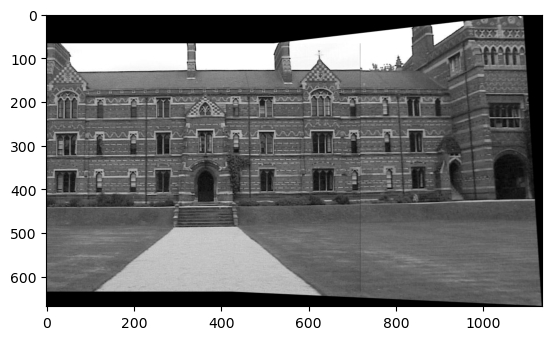

In [126]:
import cv2
import numpy as np

def create_panorama(image1, image2, H):
    """
    Crea un panorama de dos imágenes usando una matriz de homografía.

    Parámetros:
    image1: La primera imagen.
    image2: La segunda imagen.
    H: Matriz de homografía que transforma puntos de image1 a image2.

    Devuelve:
    Una imagen que es el panorama de image1 e image2.
    """
    # Obtener dimensiones de ambas imágenes
    h1, w1 = image1.shape[:2]
    h2, w2 = image2.shape[:2]

    # Obtener las esquinas de la imagen1
    corners_image1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)

    # Transformar las esquinas de la imagen1 usando la homografía H
    transformed_corners = cv2.perspectiveTransform(corners_image1, H)

    # Obtener las esquinas de la imagen2
    corners_image2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)

    # Combina las esquinas de ambas imágenes
    all_corners = np.concatenate((transformed_corners, corners_image2), axis=0)

    # Encuentra el bounding box que puede contener ambas imágenes
    [x_min, y_min] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(all_corners.max(axis=0).ravel() + 0.5)

    # Calcula las dimensiones del panorama
    panorama_size = (x_max - x_min, y_max - y_min)

    # Ajusta la matriz de transformación para el desplazamiento
    translation_dist = [-x_min, -y_min]
    H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

    # Aplica la transformación a la imagen1
    panorama = cv2.warpPerspective(image1, H_translation.dot(H), panorama_size)
    panorama[translation_dist[1]:h2+translation_dist[1], translation_dist[0]:w2+translation_dist[0]] = image2

    return panorama

reference_image = cv2.imread('images/keble_b.jpg', cv2.IMREAD_GRAYSCALE)
transform_image = cv2.imread('images/keble_c.jpg', cv2.IMREAD_GRAYSCALE)

pan1 = create_panorama(transform_image, reference_image, H)
plt.imshow(pan1, cmap='gray')

# Uso de la función
# img1 = cv2.imread('ruta_de_tu_primera_imagen.jpg')
# img2 = cv2.imread('ruta_de_tu_segunda_imagen.jpg')
# H = tu_matriz_de_homografia
# panorama = create_panorama(img1, img2, H)
# cv2.imshow('Panorama', panorama)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

## FAST Descriptors

In [ ]:
# Initiate FAST object with default values
fast = cv2.FastFeatureDetector_create()

# find and draw the keypoints
kp = fast.detect(img,None)

print('The number of keypoints with sift is {}'.format(len(kp)))

img_kp = cv2.drawKeypoints(img_gs, kp, None, color=(255,0,0))

plt.imshow(img_kp)